## Decision Tree 기반 분류 모델을 이용한 타이타닉 우주선 실종자 예측 

원본 데이터 셋 링크: https://www.kaggle.com/competitions/spaceship-titanic/overview

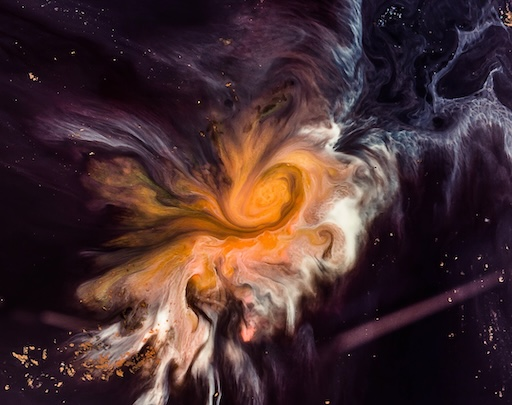

때는 2912년, 우주선 타이타닉호는 승객 13000여명을 태우고 태양계 인근의 거주 가능한 행성 3개로 항해를 하고 있었습니다. 첫번째 목적지로 향하던 도중 시공간 이상 현상과 충돌하여 승객의 절반이 다른 행성으로 이동해버렸습니다! 구조대를 돕기 위해서 승객들의 정보를 바탕으로 어느 승객이 실종 되었는지를 예측해보세요!

### ABSTRACT
Decision Tree를 기반으로 하는 분류 모델들을 활용하였습니다. 예측 과정은 1) EDA 및 데이터 전처리 2) 모델 학습 3) 최종 모델 채택의 순으로 이뤄졌습니다. 가장 높은 정확도를 보였던 모델은 Random Forest를 사용한 모델이었고, 이는 최적의 max_depth, n_estimators, max_feature 등의 하이퍼 파라미터를 Grid Search를 통해 찾은 결과였습니다. 해당 모델을 Stratified KFold 기법으로 교차검증한 후 Kaggle에 최종 제출하였습니다(정확도 0.8017).

In [1]:
import pandas as pd

train_df = pd.read_csv("./spaceship-titanic/train.csv", encoding="utf-8")
test_df = pd.read_csv("./spaceship-titanic/test.csv", encoding="utf-8")

In [2]:
# 전처리를 위해 하나로 합쳐주기

df = pd.concat([train_df, test_df]).reset_index(drop=True)

## 1. 전체 EDA & 전처리

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.4+ MB


In [4]:
# 결측치 확인
train_df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [5]:
# CryoSleep과 VIP 결측치 메우기
df["VIP"] = df["VIP"].fillna("False")
df["CryoSleep"] = df["CryoSleep"].fillna("False")

In [6]:
# CryoSleep과 VIP -> 데이터타입 변경(bool)
df["VIP"] = df["VIP"].astype(bool)
df["CryoSleep"] = df["CryoSleep"].astype(bool)

## 2. 컬럼 별 EDA & 전처리

### PassengerId

#### 📌그룹 인원 수(GroupSize)로 encoding

In [7]:
# 그룹 ID 추출
df['GroupID'] = df['PassengerId'].apply(lambda x: x.split('_')[0])

# 그룹별 인원 수 계산
group_sizes = df['GroupID'].value_counts().to_dict()

# 그룹의 인원 수로 인코딩
df['GroupSize'] = df['GroupID'].map(group_sizes)

In [8]:
# Group_size 컬럼으로 대체된 PassengerId와 GroupID는 삭제
df = df.drop(["GroupID"], axis=1)

#### 📌GroupSize 별로 Transported 된 비율 확인

In [7]:
#각 Groupsize에 속한 사람 수 확인
groupsize_cnt = df["GroupSize"].value_counts()

In [8]:
# GroupSize 별로 Transported 된 사람 몇 명인지 확인
groupsize_transported = df[df['Transported'] == 1].groupby('GroupSize').size()

In [9]:
# GroupSize 별로 transported 된 비율 확인
transported_ratio = groupsize_transported / groupsize_cnt
transported_ratio

GroupSize
1    0.452445
2    0.538050
3    0.593137
4    0.640777
5    0.592453
6    0.614943
7    0.541126
8    0.394231
dtype: float64

### Homeplanet

#### 📌Homeplanet 별로 transport된 사람 비율 확인

In [10]:
# HomePlanet 별 데이터 수
HomePlanet_cnt = df["HomePlanet"].value_counts()
HomePlanet_cnt

HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64

In [11]:
# HomePlanet 별 transported 된 수
HomePlanet_transported = df[df['Transported'] == 1].groupby('HomePlanet').size()
HomePlanet_transported

HomePlanet
Earth     1951
Europa    1404
Mars       920
dtype: int64

In [12]:
# HomePlanet 별 transported된 비율
HomePlanet_transported_ratio = HomePlanet_transported / HomePlanet_cnt
HomePlanet_transported_ratio

HomePlanet
Earth     0.423946
Europa    0.658846
Mars      0.523024
dtype: float64

#### 📌Homeplanet -> One Hot Encoding

In [11]:
# one-hot encoding
HomePlanet_dummies = pd.get_dummies(df["HomePlanet"], prefix="HomePlanet")
HomePlanet_dummies

,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars
0,False,True,False
1,True,False,False
2,False,True,False
3,False,True,False
4,True,False,False
...,...,...,...
12965,True,False,False
12966,True,False,False
12967,False,False,True
12968,False,True,False


In [12]:
df = pd.concat([df, HomePlanet_dummies], axis=1)

In [13]:
df = df.drop(["HomePlanet"], axis=1)

### ⭐CryoSleep

#### 📌CryoSleep한 사람 중 transport된 비율

In [16]:
# Cryosleep한 사람 중 transported된 사람 수 ->  꽤 높네?
cryosleep_transported = df[df['CryoSleep'] == True].groupby('Transported').size()
cryosleep_transported

Transported
False     554
True     2483
dtype: int64

### Cabin (Deck/Num/Side)

#### 📌Deck
unique 값이 너무 많아서 drop하기로 결정했는데 데이터 분석을 다시 할 때는 deck도 분석 대상에 넣고 싶다.

In [17]:
# Deck 분리
df["Deck"] = df["Cabin"].str[0]

In [18]:
# Deck unique값 확인
df["Deck"].unique()

array(['B', 'F', 'A', 'G', nan, 'E', 'D', 'C', 'T'], dtype=object)

In [19]:
# Deck을 drop하기로 결정합니다.
df = df.drop(["Deck"], axis=1)

#### 📌Side -> one hot encoding

In [ ]:
# side 분리
df["Side"] = df["Cabin"].str[-1]

In [11]:
df["Side"].unique()

array(['P', 'S', nan], dtype=object)

In [15]:
# Side -> one-hot encoding
Side_dummies = pd.get_dummies(df["Side"], prefix="Side")
Side_dummies

,Side_P,Side_S
0,True,False
1,False,True
2,False,True
3,False,True
4,False,True
...,...,...
12965,False,True
12966,False,False
12967,True,False
12968,True,False


In [16]:
df = pd.concat([df, Side_dummies], axis=1)

In [17]:
# 필요 없어진 Cabin은 drop
df = df.drop(["Cabin"], axis=1)

### ⭐Destination

In [25]:
# Destination unique값 확인
df["Destination"].unique()

array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e', nan], dtype=object)

In [85]:
#Destination 별 transported 비율 확인 -> 55 Cancri e > PSO J318.5-22 > TRAPPIST-1e 순으로 높군

Destination_cnt = df["Destination"].value_counts()
Destination_transported = df[df["Transported"]==1].groupby("Destination").size()
Destination_transported_ratio = Destination_transported / Destination_cnt

Destination_transported_ratio

Destination
55 Cancri e      0.610000
PSO J318.5-22    0.503769
TRAPPIST-1e      0.471175
dtype: float64

#### 📌Destination -> One hot encoding

In [20]:
# one-hot encoding
destination_dummies = pd.get_dummies(df["Destination"], prefix="Destination")
destination_dummies

,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,False,False,True
1,False,False,True
2,False,False,True
3,False,False,True
4,False,False,True
...,...,...,...
12965,False,False,True
12966,False,False,True
12967,True,False,False
12968,False,False,False


In [21]:
df = pd.concat([df, destination_dummies], axis=1)

In [22]:
df = df.drop(["Destination"], axis=1)

### Age

<Axes: >

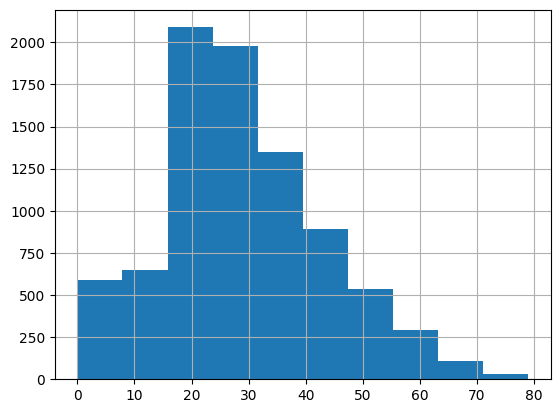

In [30]:
df["Age"].hist()

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'RoomService'}>,
        <Axes: title={'center': 'FoodCourt'}>],
       [<Axes: title={'center': 'ShoppingMall'}>,
        <Axes: title={'center': 'Spa'}>,
        <Axes: title={'center': 'VRDeck'}>],
       [<Axes: title={'center': 'GroupSize'}>, <Axes: >, <Axes: >]],
      dtype=object)

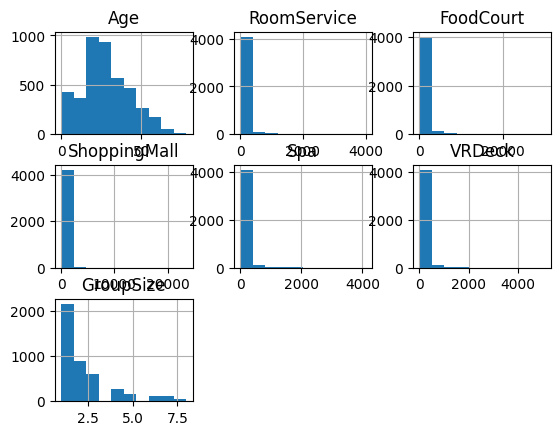

In [31]:
# tranported 된 사람들의 feature별 히스토그램
df[df['Transported'] == True].hist()

### Luxury Amenities
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck

In [23]:
# 럭셔리 아메니티에 지불한 금액의 총합을 구하기!!

df["LuxuryAmenities"] = df["RoomService"] +df["FoodCourt"] +df["ShoppingMall"] + df["Spa"] + df["VRDeck"]

In [33]:
# 세부 사항 컬럼은 drop

df = df.drop(df[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]], axis=1)

### VIP

In [34]:
VIP_cnt = df["VIP"].sum()
VIP_cnt

199

In [35]:
VIP_transported = df[df['VIP'] == True].groupby('Transported').size()

In [36]:
VIP_transport_ratio = VIP_transported / VIP_cnt
VIP_transport_ratio

Transported
False    0.61809
True     0.38191
dtype: float64

### 데이터 전처리한 것 분리하여 저장

In [24]:
train_df = df.iloc[:8693] # 머신러닝시킬 때 활용할 training 파일
test_df = df.iloc[8693:]  # 머신러닝의 결과를 검증할 때 활용할 test 파일

In [25]:
test_df = test_df.drop(["Transported"], axis=1)

In [26]:
train_df.to_csv("./spaceship-titanic/preprocessed_train.csv", index=False, encoding="utf-8")
test_df.to_csv("./spaceship-titanic/preprocessed_test.csv", index=False, encoding="utf-8")

## 2. 데이터 학습

In [27]:
train_df = pd.read_csv("./spaceship-titanic/preprocessed_train.csv", encoding="utf-8")
test_df = pd.read_csv("./spaceship-titanic/preprocessed_test.csv", encoding="utf-8")

In [28]:
# 독립변수 : Name과 같은 특정적 정보 제외시킴
x_train = train_df.drop(["PassengerId", "Name", "Transported"], axis=1)

# 종속변수 : Transported 여부
y_train = train_df["Transported"]

In [46]:
x_test = test_df.drop(["PassengerId"], axis=1)

### 📌Decision Tree Classifier (default)

In [95]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(
    criterion="entropy",
    random_state = 1234
)

In [96]:
model.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=1234)

#### Decision Tree Classifier (default) -> Stratified K Fold 교차검증

In [97]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

stratified_kf=StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=1234
)

In [98]:
cross_val_scores = cross_val_score(model, x_train, y_train, cv=stratified_kf)

In [99]:
score = cross_val_score(model, x_train, y_train, cv=stratified_kf)
score

array([0.72972973, 0.73663025, 0.72915469, 0.73302647, 0.74165708])

In [100]:
score.mean()

0.7340396415807136

#### Decision Tree Classifier (default) -> 어떤 feature가 많이 사용되었을까

In [101]:
feature_names=x_train.columns.to_list()

In [102]:
importances = model.feature_importances_
importances

array([0.17048313, 0.13702725, 0.0091221 , 0.08938788, 0.09756148,
       0.07474427, 0.12253915, 0.10733651, 0.06589148, 0.04965022,
       0.01429272, 0.0092549 , 0.01181049, 0.01256949, 0.00774904,
       0.00701067, 0.01356922])

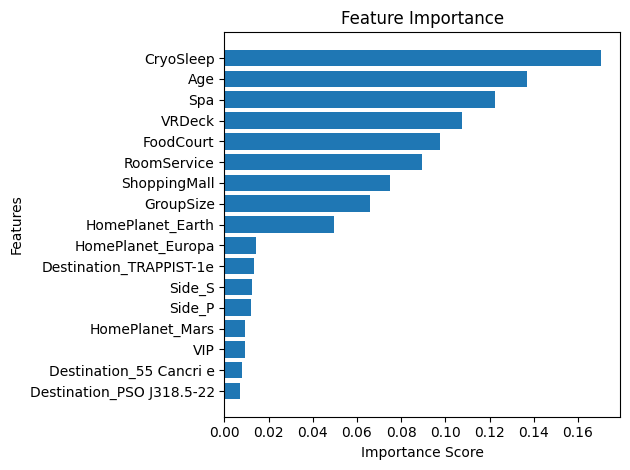

In [103]:
import numpy as np
from matplotlib import pyplot as plt

indices = np.argsort(importances)
sorted_feature_names = [feature_names[i] for i in indices]

# Create plot
plt.figure()
plt.title("Feature Importance")
ticks = range(len(feature_names))
plt.barh(ticks, importances[indices], align="center")
plt.yticks(ticks, sorted_feature_names)
plt.ylabel("Features")
plt.xlabel("Importance Score")

plt.tight_layout()
plt.show()

### 📌 Decision Tree Classifier (MaxDepth=5)

In [104]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(
    criterion="entropy",
    random_state=1234,
    max_depth=5
)

In [ ]:
model.fit(x_train, y_train)

#### Decision Tree Classifier (MaxDepth=5) -> StratifiedKFold 교차검증

In [106]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

stratified_kf=StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=1234
)

In [107]:
cross_val_scores = cross_val_score(model, x_train, y_train, cv=stratified_kf)

In [108]:
score = cross_val_score(model, x_train, y_train, cv=stratified_kf)
score

array([0.78090857, 0.76020702, 0.76883266, 0.74626007, 0.74913694])

In [109]:
score.mean()

0.7610690508347389

### 📌Random Forest (default)

In [110]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    criterion="entropy",
    max_depth=6, #하나의 tree의 depth
    random_state=1234,
    n_estimators=10 # 숲을 이루는 Tree의 개수
)

In [111]:
model.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=6, n_estimators=10,
                       random_state=1234)

#### Random Forest (default) -> StratifiedKFold 교차검증

In [112]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

stratified_kf=StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=1234
)

In [113]:
score = cross_val_score(model, x_train, y_train, cv=stratified_kf)
score

array([0.78033353, 0.76825762, 0.80736055, 0.77330265, 0.79401611])

In [114]:
score.mean()

0.7846540907138806

#### Random Forest (default) -> 어떤 feature가 많이 사용되었을까

In [47]:
feature_names=x_train.columns.to_list()

In [48]:
importances = model.feature_importances_
importances

array([0.13938278, 0.02723566, 0.00065132, 0.17080187, 0.07904029,
       0.07210538, 0.1704522 , 0.12468842, 0.00885137, 0.1145663 ,
       0.05101466, 0.0127371 , 0.01047202, 0.00737228, 0.00642104,
       0.00166741, 0.00253989])

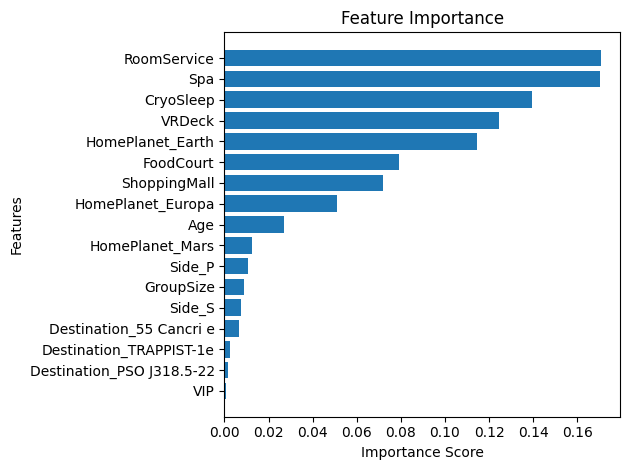

In [49]:
import numpy as np
from matplotlib import pyplot as plt

indices = np.argsort(importances)
sorted_feature_names = [feature_names[i] for i in indices]

# Create plot
plt.figure()
plt.title("Feature Importance")
ticks = range(len(feature_names))
plt.barh(ticks, importances[indices], align="center")
plt.yticks(ticks, sorted_feature_names)
plt.ylabel("Features")
plt.xlabel("Importance Score")

plt.tight_layout()
plt.show()

### 📌Boosting Tree - LIGHTGBM

In [130]:
import lightgbm as lgb

model = lgb.LGBMClassifier(verbose=-1)

In [131]:
model.fit(x_train, y_train)

LGBMClassifier(verbose=-1)

#### Boosting Tree - LIGHTGBM -> StratifiedKFold 교차검증

In [53]:
from sklearn.model_selection import StratifiedKFold

stratified_kf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=1234
)

In [133]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, x_train , y_train, cv=stratified_kf)
scores

array([0.7947096 , 0.79355952, 0.79643473, 0.7986191 , 0.787687  ])

In [134]:
score.mean()

0.7846540907138806

### 📌 Random Forest (Grid Search_1)
* n_estimators: 트리의 개수
* max_features: 개별 트리 학습시 무작위로 선택하는 피쳐 수
* max_depth: 각 트리별 최대 깊이

In [31]:
from sklearn.model_selection import GridSearchCV

In [32]:
# 첫번째 시도

param_grid = {
    "n_estimators": [10,30,50], 
    "max_depth": [3,5,10],
    "max_features": [3,5,9]
}

In [143]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=stratified_kf
)

In [147]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=RandomForestClassifier(criterion='entropy', max_depth=6,
                                              n_estimators=10,
                                              random_state=1234),
             param_grid={'max_depth': [5, 10, 15], 'max_features': [3, 5, 9],
                         'n_estimators': [50, 70, 90]})

In [141]:
grid_search.best_params_, grid_search.best_score_

({'max_depth': 10, 'max_features': 3, 'n_estimators': 50}, 0.8001836299977965)

### 📌 Random Forest (Grid Search_2)

In [146]:
# 두 번째 시도

param_grid = {
    "n_estimators": [50, 70, 90], 
    "max_depth": [3, 5, 10],
    "max_features": [3, 5, 9]
}

In [ ]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=stratified_kf
)

In [ ]:
grid_search.fit(x_train, y_train)

In [145]:
grid_search.best_params_, grid_search.best_score_

({'max_depth': 10, 'max_features': 3, 'n_estimators': 70}, 0.8007591363368365)

#### Random Forest (Grid Search_2) -> 어떤 feature이 중요했을까

In [38]:
feature_names=x_train.columns.to_list()

In [42]:
importances = model.feature_importances_
importances

array([0.10407543, 0.06493655, 0.00481879, 0.1164864 , 0.09158769,
       0.06810954, 0.1240574 , 0.10517524, 0.02843469, 0.05231533,
       0.04237069, 0.01618529, 0.01101525, 0.01221615, 0.01241172,
       0.00528578, 0.00883628, 0.13168178])

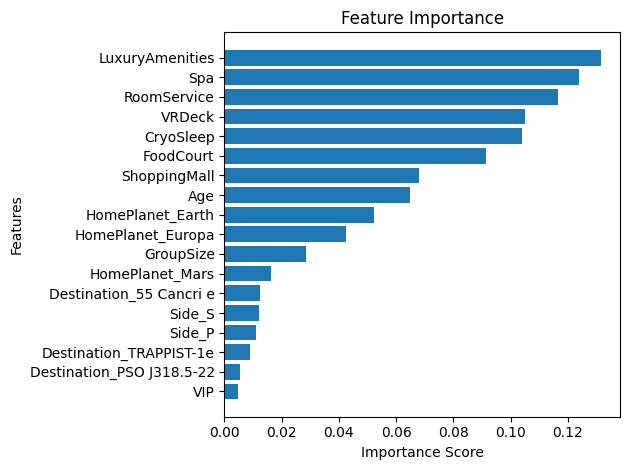

In [43]:
import numpy as np
from matplotlib import pyplot as plt

indices = np.argsort(importances)
sorted_feature_names = [feature_names[i] for i in indices]

# Create plot
plt.figure()
plt.title("Feature Importance")
ticks = range(len(feature_names))
plt.barh(ticks, importances[indices], align="center")
plt.yticks(ticks, sorted_feature_names)
plt.ylabel("Features")
plt.xlabel("Importance Score")

plt.tight_layout()
plt.show()

### 📌Random Forest (Grid Search_3)

In [33]:
#세 번째 시도

param_grid = {
    "n_estimators": [70, 80],
    "max_depth": [10],
    "max_features": [3]
}

In [35]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=stratified_kf
)

In [36]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=RandomForestClassifier(criterion='entropy', max_depth=6,
                                              n_estimators=10,
                                              random_state=1234),
             param_grid={'max_depth': [10], 'max_features': [3],
                         'n_estimators': [70, 80]})

In [37]:
grid_search.best_params_, grid_search.best_score_

({'max_depth': 10, 'max_features': 3, 'n_estimators': 70}, 0.798918468942708)

## 3. 캐글에 제출

In [40]:
model = RandomForestClassifier(
    criterion="entropy",
    max_depth=10,
    random_state=1234,
    n_estimators=70,
    max_features=3
)

In [41]:
model.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, max_features=3,
                       n_estimators=70, random_state=1234)

In [ ]:
y_test = model.predict(x_test)

In [39]:
test_df["Transported"] = y_test

In [46]:
test_df["Transported"] = test_df["Transported"].astype(bool)

In [47]:
# 제출 파일 (csv) 형성
test_df[["PassengerId", "Transported"]].to_csv("./spaceship-titanic/submission_grid_search.csv", index= False)

In [48]:
# 제출 파일 확인
submission_df = pd.read_csv("./spaceship-titanic/submission_grid_search.csv", encoding="utf-8")